# This notebook implements and tests a simple gravitational wave likelihood

We begin by loading the Mathematica notebook `simplified_model.nb`.

In this notebook we've coded up the simple TaylorF2 model, and take derivatives using Mathematica.

We then ask chatGPT to rewrite the mathematica code into JAX format

In [ ]:
import jax.numpy as jnp
from jax import grad, config
import jax
import matplotlib.pyplot as plt
import os 
import numpy as np

config.update("jax_enable_x64", True)

def strain(x, frequency):
    m_sunsec = 5e-6 # Conversion from solar masses to seconds
    
    time_coalescence = x[0]
    phase_coalescence =x[1]
    Mc = x[2] * m_sunsec
    eta = x[3]
    amplitude = x[4]
    
    # eta = symmetric_mass_ratio
    # Mc = chirp_mass
    
    term = amplitude * jnp.exp(-1j * (-(jnp.pi/4) + 2 * jnp.pi * frequency * time_coalescence + (
        3 * (1 + jnp.pi**(2/3) * ((frequency * Mc) / eta**(3/5))**(2/3) * (3715/756 + (55 * eta)/9)))/(
        128 * jnp.pi**(5/3) * ((frequency * Mc) / eta**(3/5))**(5/3) * eta) - phase_coalescence)) / frequency**(7/6)
    
    return term

def gradient_strain(x, frequency):
    m_sunsec = 5e-6 # Conversion from solar masses to seconds

    t = x[0]
    phi = x[1]
    Mc = x[2] * m_sunsec
    eta = x[3]
    A = x[4]
    
    term1 = jnp.exp(-1j * (-(jnp.pi/4) + 2 * jnp.pi * frequency * t +
                         (756 + 5 * jnp.pi**(2/3) * ((frequency * Mc)/eta**(3/5))**(2/3) * (743 + 924 * eta)) / 
                         (32256 * jnp.pi**(5/3) * ((frequency * Mc)/eta**(3/5))**(5/3) * eta) - phi)) / frequency**(7/6)
    
    term2 = -((2j * A * jnp.exp(-1j * (-(jnp.pi/4) + 2 * jnp.pi * frequency * t +
                                       (756 + 5 * jnp.pi**(2/3) * ((frequency * Mc)/eta**(3/5))**(2/3) * (743 + 924 * eta)) / 
                                       (32256 * jnp.pi**(5/3) * ((frequency * Mc)/eta**(3/5))**(5/3) * eta) - phi)) * jnp.pi) /
              frequency**(1/6))
    
    term3 = (1j * A * jnp.exp(-1j * (-(jnp.pi/4) + 2 * jnp.pi * frequency * t +
                                     (756 + 5 * jnp.pi**(2/3) * ((frequency * Mc)/eta**(3/5))**(2/3) * (743 + 924 * eta)) / 
                                     (32256 * jnp.pi**(5/3) * ((frequency * Mc)/eta**(3/5))**(5/3) * eta) - phi))) / frequency**(7/6)
    
    term4 = -(((-1)**(3/4) * A * jnp.exp(-2j * frequency * jnp.pi * t - 
                                         (3j) / (128 * jnp.pi**(5/3) * ((frequency * Mc)/eta**(3/5))**(5/3) * eta) - 
                                         (5j * (743 + 924 * eta)) / (32256 * frequency * Mc * jnp.pi * eta**(2/5)) + 
                                         1j * phi) * (-743 + 1386 * eta)) / 
              (16128 * frequency**(13/6) * Mc * jnp.pi * eta**(7/5)))
    
    term5 = (5 * (-1)**(3/4) * A * jnp.exp(-2j * frequency * jnp.pi * t - 
                                           (3j) / (128 * jnp.pi**(5/3) * ((frequency * Mc)/eta**(3/5))**(5/3) * eta) - 
                                           (5j * (743 + 924 * eta)) / (32256 * frequency * Mc * jnp.pi * eta**(2/5)) + 
                                           1j * phi) * (252 + jnp.pi**(2/3) * ((frequency * Mc)/eta**(3/5))**(2/3) * (743 + 924 * eta))) / \
            (32256 * frequency**(1/6) * jnp.pi**(5/3) * ((frequency * Mc)/eta**(3/5))**(8/3) * eta**(8/5))
    
    return jnp.array([term1, term2, term3, term4, term5])


## Make sure the evaluations agree with Mathematica

In [ ]:
# Given variables
time_coalescence = 1.0
amplitude = 2.0
symmetric_mass_ratio = 0.25
chirp_mass = 30.0
phase_coalescence = 0.5
frequency = jnp.linspace(10, 1000, 1)

# Input to the function (x)
x = jnp.array([time_coalescence, phase_coalescence, chirp_mass, symmetric_mass_ratio, amplitude])

# Evaluate and print the output from the strain function
strain_output = strain(x, frequency)
print("Strain:", strain_output)

# Evaluate and print the output from the gradient of the strain function
grad_strain_output = gradient_strain(x, frequency)
print(grad_strain_output)

# Derivatives agree but are out of order?
print(jax.jacfwd(strain)(x, frequency))

## Make a quick plot for first glance check

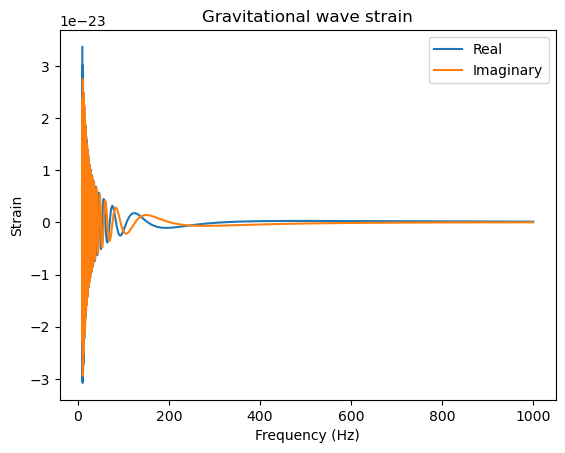

In [27]:
# Plot the strain
injection = jnp.array([0, 0, 30.0, 0.24, 5e-22])
# injection = jnp.array([0.0, 0.5, 300.0, 0.25, 1e-20])
# injection = np.array([0, 0.5, 30.0, 0.25, 1e-40])
# injection = np.array([0, 0, 30.0, 0.25, 1e-40])
frequency = jnp.linspace(10, 1000, num=10000)
h = strain(injection, frequency)
fig, ax = plt.subplots()
ax.plot(frequency, h.real, label='Real')
ax.plot(frequency, h.imag, label='Imaginary')
ax.set_title('Gravitational wave strain')
ax.set_ylabel('Strain')
ax.set_xlabel('Frequency (Hz)')
ax.legend()

In [28]:
""" 
Parameter order:
time_coalescence = x[0]
phase_coalescence = x[1]
chirp_mass = x[2]
symmetric_mass_ratio = x[3]
amplitude = x[4]
"""

# Defined fixed frequency grid
fmin = 10
fmax = 1000
n_bins = 1000
frequency = jnp.linspace(10, 1000, num=n_bins+1)
deltaf = (fmax - fmin) / n_bins

# Load noise data and store power spectral density over defined grid
asd_path = os.path.join(os.getcwd(), 'aLIGO_O4_high_asd.txt')
asd = np.loadtxt(asd_path, usecols=(0,1))
freq_data = asd[:,0]
psd_data = asd[:,1] ** 2
PSD = jnp.interp(frequency, freq_data, psd_data, left=1., right=1.).squeeze()

# Precompute strain corresponding to injection 
injection = jnp.array([0, 0, 30.0, 0.24, 5e-22])
data = strain(injection, frequency)

# @jax.jit
def potential_single(x):
    square_norm = lambda a, power_spectral_density, frequency_spacing: (4 * jnp.sum((a.real[..., :-1] ** 2 + a.imag[..., :-1] ** 2) / power_spectral_density[..., :-1] * frequency_spacing, axis=-1)).T

    residual = strain(x, frequency) - data

    return 0.5 * square_norm(residual, power_spectral_density=PSD, frequency_spacing=deltaf)

# @jax.jit   
def gradient_potential_single(x):
    overlap = lambda a, b, power_spectral_density, frequency_spacing: (4 * jnp.sum(a.conjugate()[..., :-1] * b[..., :-1] / power_spectral_density[..., :-1] * frequency_spacing, axis=-1)).T

    residual = strain(x, frequency) - data

    return overlap(gradient_strain(x, frequency), residual, power_spectral_density=PSD, frequency_spacing=deltaf)

@jax.jit
def potential(X):
    return jax.vmap(potential_single)(X)

@jax.jit
def gradient_potential(X):
    return jax.vmap(gradient_potential_single)(X)

def signal_noise_ratio(x):
    s = strain(x, frequency)
    square_norm = lambda a, power_spectral_density, frequency_spacing: (4 * jnp.sum((a.real[..., :-1] ** 2 + a.imag[..., :-1] ** 2) / power_spectral_density[..., :-1] * frequency_spacing, axis=-1)).T
    return square_norm(s, PSD, deltaf)






In [ ]:
noise = np.random.uniform(20, size=(20,5))
print(potential(x + noise))
res = gradient_potential(x+noise)

In [31]:
# frequency = jnp.linspace(10, 1000, num=1000)
# injection = jnp.array([0, 0, 30.0, 0.24, 1e-20])
# injection = jnp.array([0, 0, 30.0, 0.24, 5e-22])

SNR = jnp.sqrt(signal_noise_ratio(injection))

# Define ranges for prior
priorDict = {}
# priorDict['time_coalescence'] = [-0.01, 0.01]
# priorDict['phase_coalescence'] = [-0.01, 0.01]
# priorDict['chirp_mass'] = [25, 35]
# priorDict['symmetric_mass_ratio'] = [0.235, 0.249]
# priorDict['amplitude'] = injection[4] * np.array([0.9, 1.1])

priorDict[0] = jnp.array([-0.01, 0.01])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
priorDict[2] = jnp.array([20, 40])
priorDict[3] = jnp.array([0.1, 0.249])
priorDict[4] = injection[4] * jnp.array([0.8, 1.2])


DoF = 5

def getCrossSection(index1, index2, func, ngrid):
    # a, b are the parameters for which we want the marginals:
    x = np.linspace(priorDict[index1][0], priorDict[index1][1], ngrid)
    y = np.linspace(priorDict[index2][0], priorDict[index2][1], ngrid)
    X, Y = np.meshgrid(x, y)
    particle_grid = np.zeros((ngrid ** 2, DoF))
    # index1 = self.gwfast_param_order.index(a)
    # index2 = self.gwfast_param_order.index(b)
    parameter_mesh = np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T
    particle_grid[:, index1] = parameter_mesh[:, 0]
    particle_grid[:, index2] = parameter_mesh[:, 1]
    for i in range(DoF): # Fix all other parameters
        if i != index1 and i != index2:
            particle_grid[:, i] = np.ones(ngrid ** 2) * injection[i]
    # Z = np.exp(-1 * func(particle_grid).reshape(ngrid,ngrid))
    Z = func(particle_grid).reshape(ngrid,ngrid)
    # s = self.getGradientMinusLogPosterior_ensemble(particle_grid)
    # Z = np.linalg.norm(s,axis=1).reshape(ngrid,ngrid)
    fig, ax = plt.subplots(figsize = (5, 5))
    cp = ax.contourf(X, Y, Z)
    # cbar = fig.colorbar(cp)
    plt.colorbar(cp)
    ax.set_xlabel(index1)
    ax.set_ylabel(index2)
    ax.set_title('Likelihood cross section')
    filename = str(index1) + str(index2) + '.png'
    path = os.path.join('marginals', filename)
    # fig.savefig(path)


In [26]:
injection = jnp.array([0, 0, 30.0, 0.24, 5e-22])

SNR = jnp.sqrt(signal_noise_ratio(injection))

print(SNR)

18.54937612984922


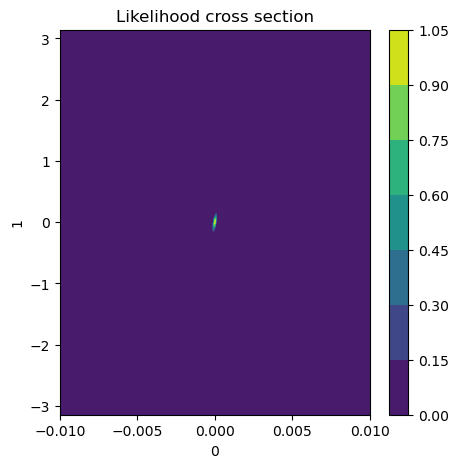

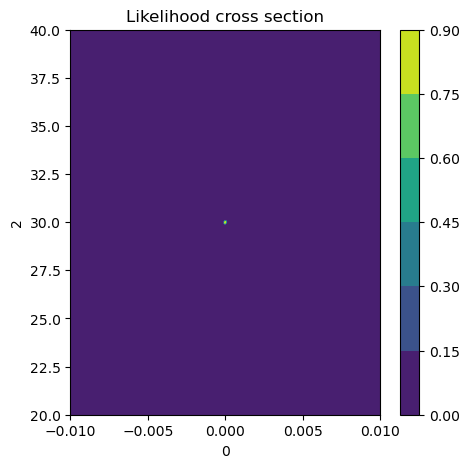

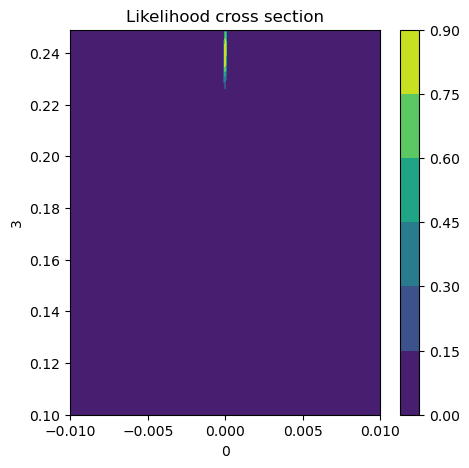

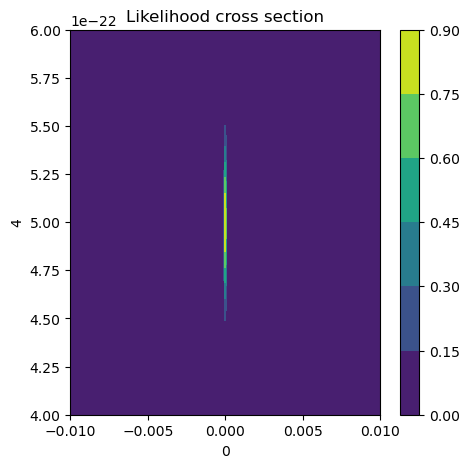

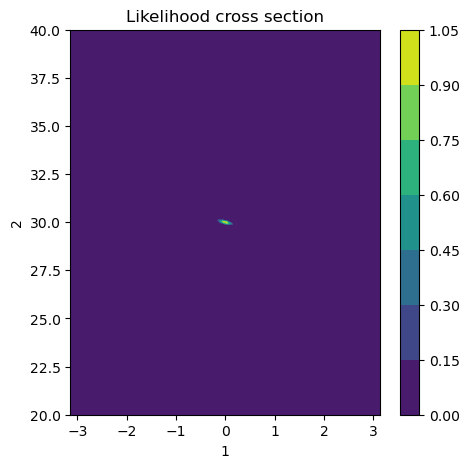

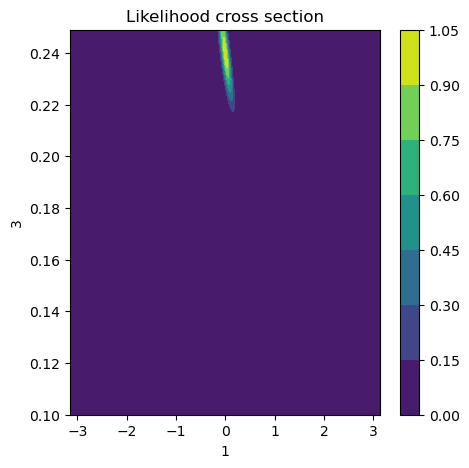

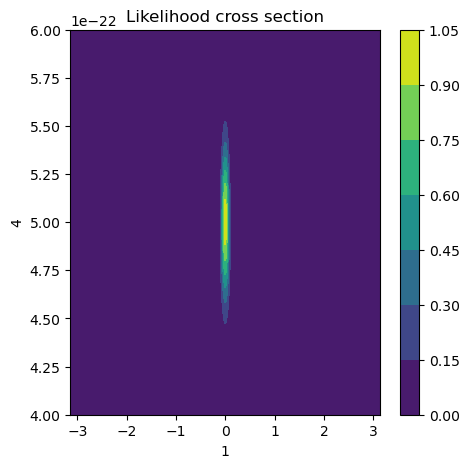

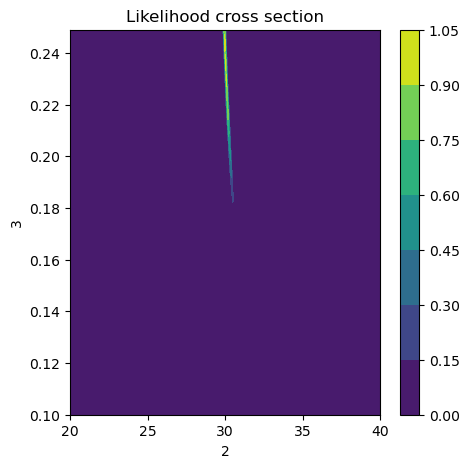

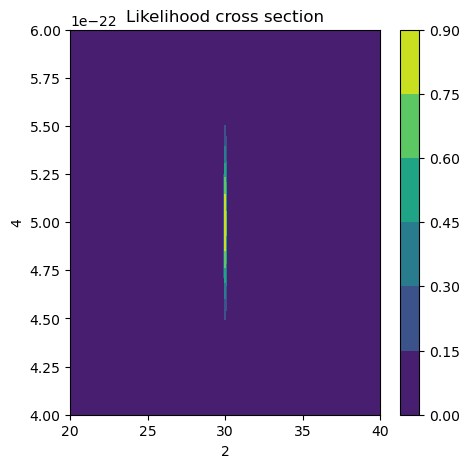

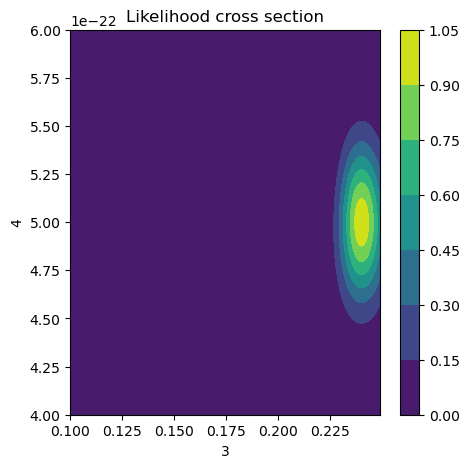

In [32]:
posterior = lambda X: np.exp(-1 * potential(X))

neg_potential = lambda X: -1 * potential(X)

for i in range(5):
    for j in range(i+1, 5):
        # print('Getting cross section for %s' % pair)
        getCrossSection(i, j, posterior, 400)
        # getCrossSection(i, j, neg_potential, 200)

